In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utide

print(utide.__version__)

0.3.1


In [2]:
# pip install utide

Look at the data file to see what structure it has.

In [3]:
# with open("can1998.dtf") as f:
#     lines = f.readlines()

# print("".join(lines[:5]))


It looks like the fields are seconds, year, month, day, hour, elevation, flag.  We need a date parser function to combine the date and time fields into a single value to be used as the datetime index.

In [4]:
# names = ["seconds", "year", "month", "day", "hour", "elev", "flag"]

# obs = pd.read_csv(
#     "can1998.dtf",
#     names=names,
#     skipinitialspace=True,
#     delim_whitespace=True,
#     na_values="9.990",
# )


# date_cols = ["year", "month", "day", "hour"]
# index = pd.to_datetime(obs[date_cols])
# obs = obs.drop(date_cols, axis=1)
# obs.index = index
obs=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/noaa_9415020_9415020_water_level_1950_2021.csv",skiprows=8,parse_dates=['Date Time'])#dtype=datatypes)

obs.head(5)

,Date Time,Water Level,Sigma,O or I (for verified),F,R,L,Quality
0,1995-12-01 00:00:00,NaN,NaN,1,1,1,1,p
1,1995-12-01 00:06:00,NaN,NaN,1,1,1,1,p
2,1995-12-01 00:12:00,NaN,NaN,1,1,1,1,p
3,1995-12-01 00:18:00,NaN,NaN,1,1,1,1,p
4,1995-12-01 00:24:00,NaN,NaN,1,1,1,1,p


In [5]:
obs.keys()

Index(['Date Time', ' Water Level', ' Sigma', ' O or I (for verified)', ' F',
       ' R', ' L', ' Quality '],
      dtype='object')

In [6]:
#rename the columns
obs=obs.rename(columns={' Water Level': "Water Level", ' Sigma': "Sigma", ' O or I (for verified)': "O or I (for verified)", ' F': "F",' R': "R", ' L': "L", ' Quality ': "Quality"})
obs.keys()

Index(['Date Time', 'Water Level', 'Sigma', 'O or I (for verified)', 'F', 'R',
       'L', 'Quality'],
      dtype='object')

In [7]:
obs["Quality"] # according to this site p is preliminary and v is verified

0          p
1          p
2          p
3          p
4          p
          ..
2261770    v
2261771    v
2261772    v
2261773    v
2261774    v
Name: Quality, Length: 2261775, dtype: object

In [8]:
pd.isna(obs["Water Level"])

0           True
1           True
2           True
3           True
4           True
           ...  
2261770    False
2261771    False
2261772    False
2261773    False
2261774    False
Name: Water Level, Length: 2261775, dtype: bool

In [9]:
# flagarray1=np.zeros(len(obs.Quality))
# flagarray1[np.where(pd.isna(obs["Water Level"])==True)]=2

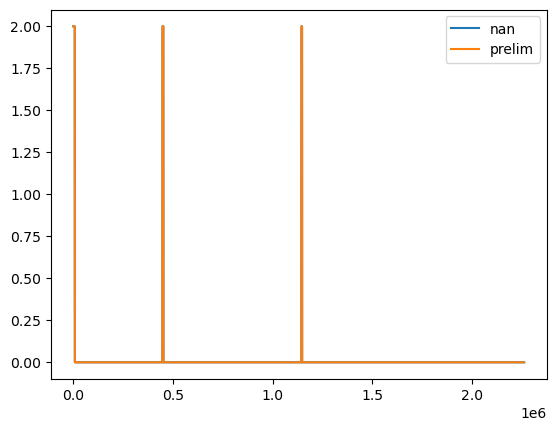

In [10]:
#to match the example add a "flag" variable sent to 2 for p and 0 for v
flagarray1=np.zeros(len(obs.Quality))
flagarray2=np.zeros(len(obs.Quality))
flagarray1[np.where(pd.isna(obs["Water Level"])==True)]=2
flagarray2[np.where(obs["Quality"]=='p')]=2

fig, ax = plt.subplots()
ax.plot(flagarray1,label='nan')
ax.plot(flagarray2,label='prelim')
ax.legend()
plt.show()

In [12]:
obs["flag"]=flagarray1
obs.index=obs['Date Time']
obs["elev"]=obs['Water Level']

Although there are no elevations marked bad via special value, which should be `nan` after reading the file, the flag value of 2 indicates the values are unreliable, so we will mark them with `nan`, calculate the deviations of the elevations from their mean (stored in a new column called "anomaly"), and then interpolate to fill in the `nan` values in the anomaly.

In [13]:
bad = obs["flag"] == 2
corrected = obs["flag"] == 1

obs.loc[bad, "elev"] = np.nan
obs["anomaly"] = obs["elev"] - obs["elev"].mean()
obs["anomaly"] = obs["anomaly"].interpolate()
print(f"{bad.sum()} points were flagged 'bad' and interpolated")
print(f"{corrected.sum()} points were flagged 'corrected' and left unchanged")

15470 points were flagged 'bad' and interpolated
0 points were flagged 'corrected' and left unchanged


In [14]:
obs["anomaly"]

Date Time
1995-12-01 00:00:00         NaN
1995-12-01 00:06:00         NaN
1995-12-01 00:12:00         NaN
1995-12-01 00:18:00         NaN
1995-12-01 00:24:00         NaN
                         ...   
2021-10-01 23:30:00   -0.483993
2021-10-01 23:36:00   -0.495993
2021-10-01 23:42:00   -0.511993
2021-10-01 23:48:00   -0.550993
2021-10-01 23:54:00   -0.594993
Name: anomaly, Length: 2261775, dtype: float64

Now we can call solve to obtain the coefficients.

In [15]:
#see parameter description in _solve.py https://github.com/wesleybowman/UTide/blob/master/utide/_solve.py
coef = utide.solve(
    obs.index,
    obs["anomaly"],
    lat=37.995, #point reyes latitude is 37.995
    method="ols", #ols is default, ordinary least squares
    conf_int="MC", #Monte Carlo confidence intervals
    verbose=False, #default is true, no messages with False
)

The amplitudes and phases from the fit are now in the `coef` data structure (a Bunch), which can be used directly in the `reconstruct` function to generate a hindcast or forecast of the tides at the times specified in the `time` array.

In [16]:
print(coef.keys())

dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn', 'PE', 'SNR'])


In [17]:
tide = utide.reconstruct(obs.index, coef, verbose=False)

The output from the reconstruction is also a Bunch:

In [18]:
print(tide.keys())

dict_keys(['t_in', 'epoch', 'constit', 'min_SNR', 'min_PE', 't_mpl', 'h'])


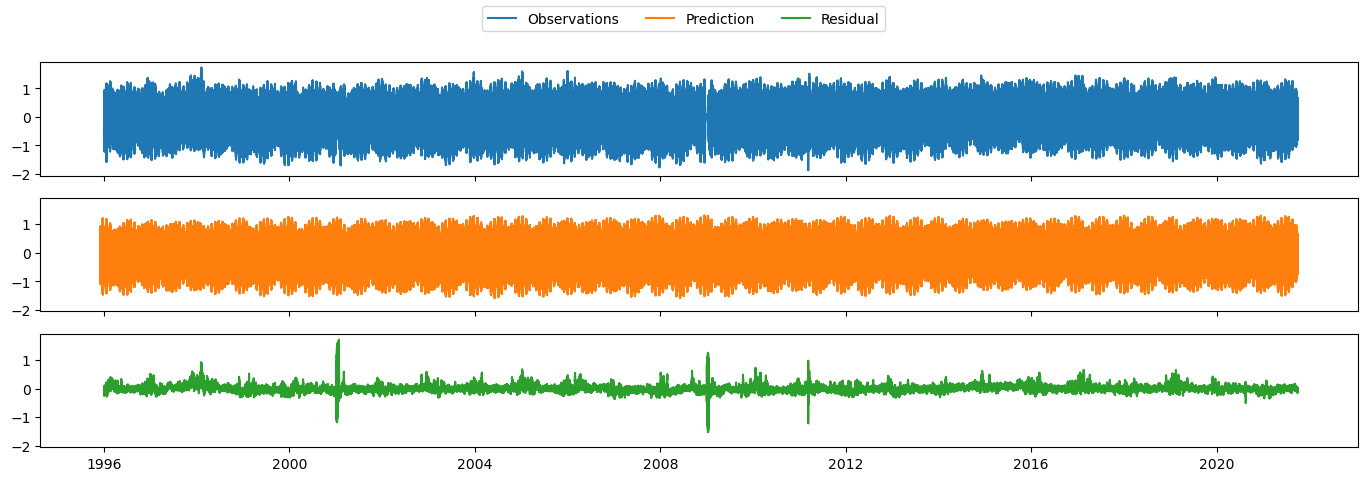

In [19]:
t = obs.index.to_pydatetime()

fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 5), nrows=3, sharey=True, sharex=True)

ax0.plot(t, obs.anomaly, label="Observations", color="C0")
ax1.plot(t, tide.h, label="Prediction", color="C1")
ax2.plot(t, obs.anomaly - tide.h, label="Residual", color="C2")
fig.legend(ncol=3, loc="upper center");

In [21]:
from datetime import datetime, timedelta

(16071.0, 16077.0)

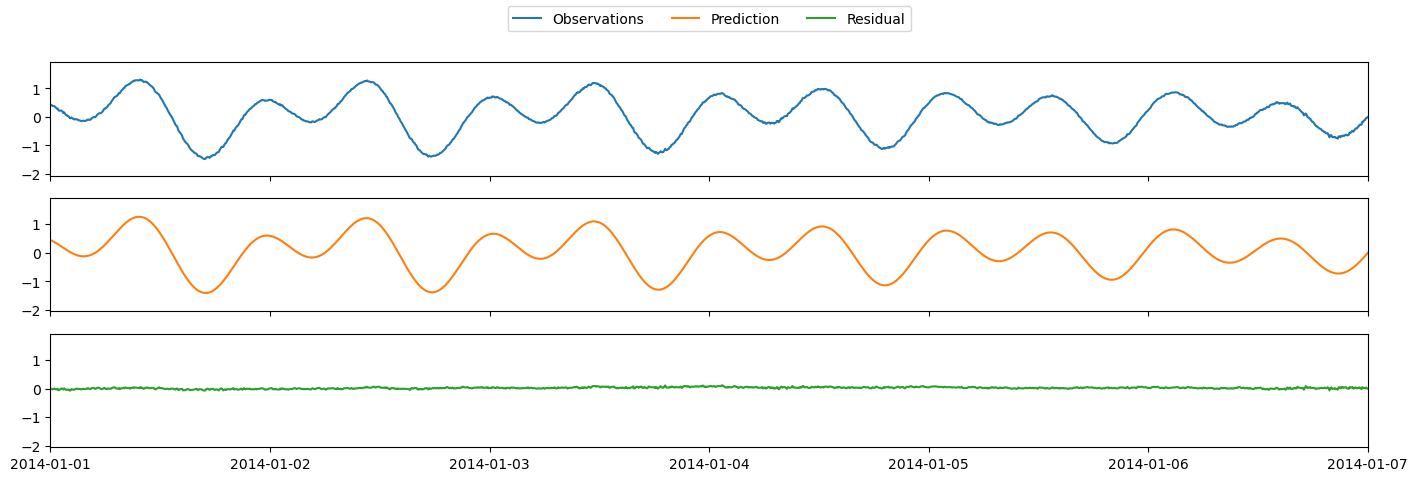

In [22]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 5), nrows=3, sharey=True, sharex=True)

ax0.plot(t, obs.anomaly, label="Observations", color="C0")
ax1.plot(t, tide.h, label="Prediction", color="C1")
ax2.plot(t, obs.anomaly - tide.h, label="Residual", color="C2")
fig.legend(ncol=3, loc="upper center");

ax0.set_xlim([datetime(2014,1,1), datetime(2014,1,7)])
ax1.set_xlim([datetime(2014,1,1), datetime(2014,1,7)])
ax2.set_xlim([datetime(2014,1,1), datetime(2014,1,7)])

In [24]:
#repear for monterey bay and compare residuals with total resideal for what sam calculated
obs_mb=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/noaa_9413450_9413450_water_level_1950_2021.csv",skiprows=8,parse_dates=['Date Time'])#dtype=datatypes)
obs_mb=obs_mb.rename(columns={' Water Level': "Water Level", ' Sigma': "Sigma", ' O or I (for verified)': "O or I (for verified)", ' F': "F",' R': "R", ' L': "L", ' Quality ': "Quality"})
flagarray2=np.zeros(len(obs_mb.Quality))
flagarray2[np.where(obs_mb["Quality"]=='p')]=2
obs_mb["flag"]=flagarray2
obs_mb.index=obs_mb['Date Time']
obs_mb["elev"]=obs_mb['Water Level']

In [25]:
bad = obs_mb["flag"] == 2
corrected = obs_mb["flag"] == 1

obs_mb.loc[bad, "elev"] = np.nan
obs_mb["anomaly"] = obs_mb["elev"] - obs_mb["elev"].mean()
obs_mb["anomaly"] = obs_mb["anomaly"].interpolate()
print(f"{bad.sum()} points were flagged 'bad' and interpolated")
print(f"{corrected.sum()} points were flagged 'corrected' and left unchanged")

11086 points were flagged 'bad' and interpolated
0 points were flagged 'corrected' and left unchanged


In [26]:
coef_mb = utide.solve(
    obs_mb.index,
    obs_mb["anomaly"],
    lat=36.608333, #monterey bay latitude is 37.995
    method="ols", #ols is default, ordinary least squares
    conf_int="MC", #Monte Carlo confidence intervals
    verbose=True, #default is true, no messages with False
)

solve: matrix prep ... solution ... done.


In [27]:
tide_mb = utide.reconstruct(obs_mb.index, coef_mb, verbose=True)

prep/calcs ... done.


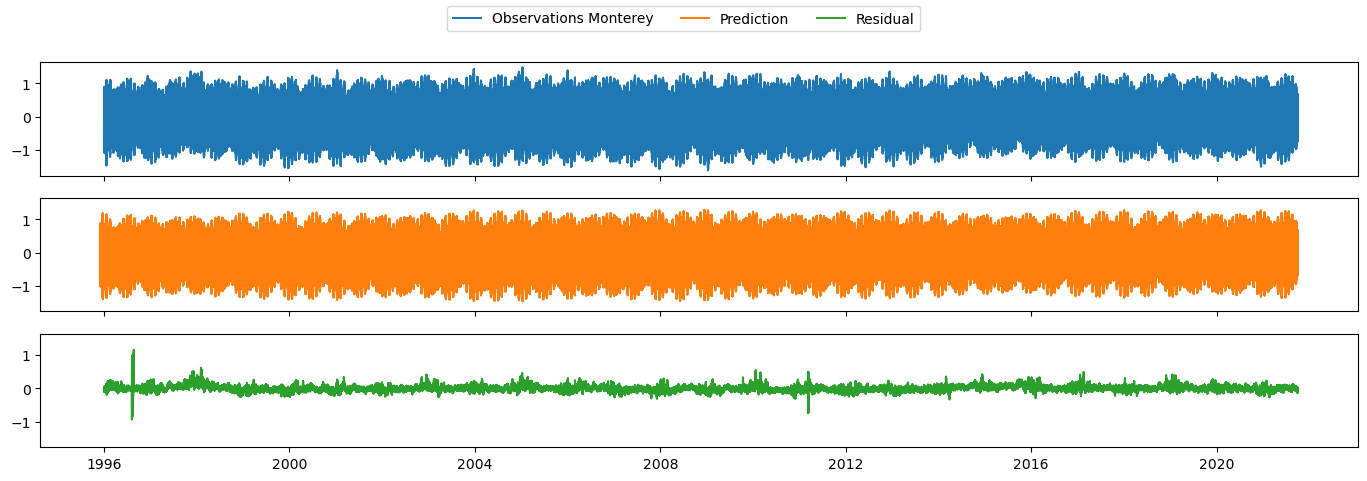

In [28]:
t = obs_mb.index.to_pydatetime()

fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 5), nrows=3, sharey=True, sharex=True)

ax0.plot(t, obs_mb.anomaly, label="Observations Monterey", color="C0")
ax1.plot(t, tide_mb.h, label="Prediction", color="C1")
ax2.plot(t, obs_mb.anomaly - tide_mb.h, label="Residual", color="C2")
fig.legend(ncol=3, loc="upper center");

# ax0.set_xlim([datetime(2014,1,1), datetime(2014,1,7)])
# ax1.set_xlim([datetime(2014,1,1), datetime(2014,1,7)])
# ax2.set_xlim([datetime(2014,1,1), datetime(2014,1,7)])

In [29]:
#now compare with Sam's residuals
mb_sam=pd.read_fwf("/global/scratch/users/jennaisrael/time_varying_data/slr_data_sam/data4regrbuild.daily.era5.monterey.norm0.txt")
mb_sam.columns=["Year", "Month", "Day", "ResWL_lo", "ResWL_hi", "SLPa", "TASa", "N34a", "PDOa", "U10a", "V10a"]
mb_sam

,Year,Month,Day,ResWL_lo,ResWL_hi,SLPa,TASa,N34a,PDOa,U10a,V10a
0,1973,11,12,-0.02788,0.05941,-2.01526,1.15286,-2.07505,-1.28235,0.58345,62.36506
1,1973,11,13,-0.02278,0.01739,0.51379,0.14197,-2.08711,-1.28528,-10.66715,35.28530
2,1973,11,14,-0.01262,-0.03827,2.04980,0.37289,-2.09914,-1.28824,-9.67575,30.52757
3,1973,11,15,-0.00850,-0.06106,2.26141,0.08441,-2.11116,-1.29122,-12.71806,30.81868
4,1973,11,16,-0.02547,0.00956,-3.54065,0.87811,-2.11025,-1.27463,-8.62905,67.52818
...,...,...,...,...,...,...,...,...,...,...,...
17092,2020,12,27,-0.00009,0.01417,-1.68414,-1.22424,-1.32486,-0.91245,-1.72206,2.64090
17093,2020,12,28,0.00145,0.13299,-12.65814,-1.16611,-1.32366,-0.91397,9.90384,20.82512
17094,2020,12,29,0.00355,0.00568,0.04828,-0.54269,-1.32248,-0.91541,10.16266,-30.99345
17095,2020,12,30,0.00470,-0.07551,7.64056,-0.49118,-1.32132,-0.91676,2.84751,-3.36609


In [33]:
#mb_sam["datetime"]=pd.to_datetime(mb_sam["Month"]+mb_sam["Day"]+mb_sam["Year"],format='%m-%d-%Y')
mb_sam["date"]=pd.to_datetime(mb_sam[['Year', 'Month', 'Day']])
mb_sam.index=mb_sam["date"]
mb_sam

,Year,Month,Day,ResWL_lo,ResWL_hi,SLPa,TASa,N34a,PDOa,U10a,V10a,date
date,,,,,,,,,,,,
1973-11-12,1973,11,12,-0.02788,0.05941,-2.01526,1.15286,-2.07505,-1.28235,0.58345,62.36506,1973-11-12
1973-11-13,1973,11,13,-0.02278,0.01739,0.51379,0.14197,-2.08711,-1.28528,-10.66715,35.28530,1973-11-13
1973-11-14,1973,11,14,-0.01262,-0.03827,2.04980,0.37289,-2.09914,-1.28824,-9.67575,30.52757,1973-11-14
1973-11-15,1973,11,15,-0.00850,-0.06106,2.26141,0.08441,-2.11116,-1.29122,-12.71806,30.81868,1973-11-15
1973-11-16,1973,11,16,-0.02547,0.00956,-3.54065,0.87811,-2.11025,-1.27463,-8.62905,67.52818,1973-11-16
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,2020,12,27,-0.00009,0.01417,-1.68414,-1.22424,-1.32486,-0.91245,-1.72206,2.64090,2020-12-27
2020-12-28,2020,12,28,0.00145,0.13299,-12.65814,-1.16611,-1.32366,-0.91397,9.90384,20.82512,2020-12-28
2020-12-29,2020,12,29,0.00355,0.00568,0.04828,-0.54269,-1.32248,-0.91541,10.16266,-30.99345,2020-12-29


In [34]:
mb_sam['ResWL_total']=mb_sam["ResWL_hi"]+mb_sam["ResWL_lo"]

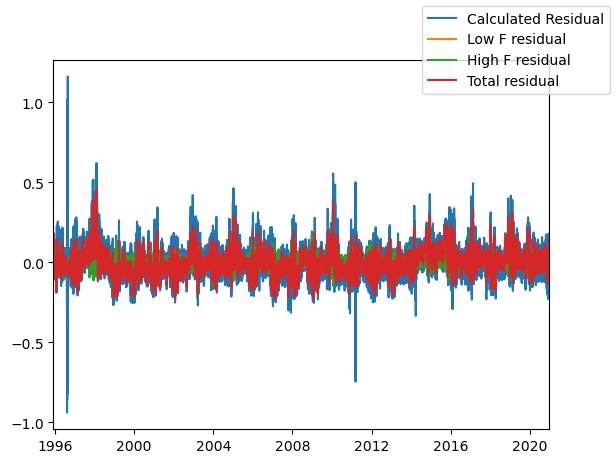

In [35]:
fig, ax =plt.subplots()

ax.plot(t, obs_mb.anomaly - tide_mb.h, label="Calculated Residual") #color="C2")
ax.plot(mb_sam["date"],mb_sam["ResWL_lo"],label="Low F residual")
ax.plot(mb_sam["date"],mb_sam["ResWL_hi"],label="High F residual")
ax.plot(mb_sam["date"],mb_sam["ResWL_total"],label="Total residual")

ax.set_xlim([datetime(1995,12,1,1),datetime(2020,12,31)])
fig.legend()

# ax0.set_xlim([datetime(2014,1,1), datetime(2014,1,7)])
# ax1.set_xlim([datetime(2014,1,1), datetime(2014,1,7)])
# ax2.set_xlim([datetime(2014,1,1), datetime(2014,1,7)])

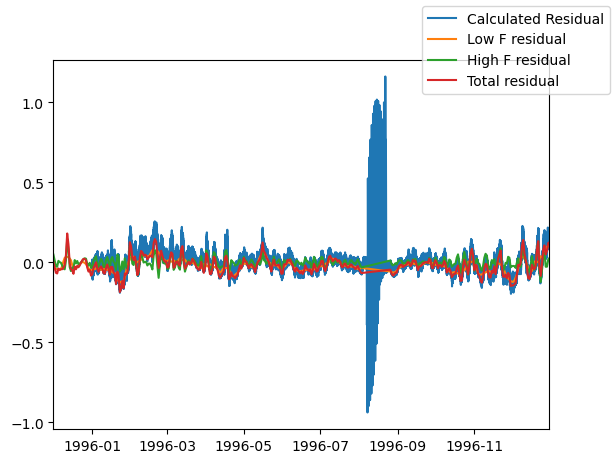

In [36]:
fig, ax =plt.subplots()

ax.plot(t, obs_mb.anomaly - tide_mb.h, label="Calculated Residual") #color="C2")
ax.plot(mb_sam["date"],mb_sam["ResWL_lo"],label="Low F residual")
ax.plot(mb_sam["date"],mb_sam["ResWL_hi"],label="High F residual")
ax.plot(mb_sam["date"],mb_sam["ResWL_total"],label="Total residual")

ax.set_xlim([datetime(1995,12,1,1),datetime(1996,12,31)])
fig.legend()

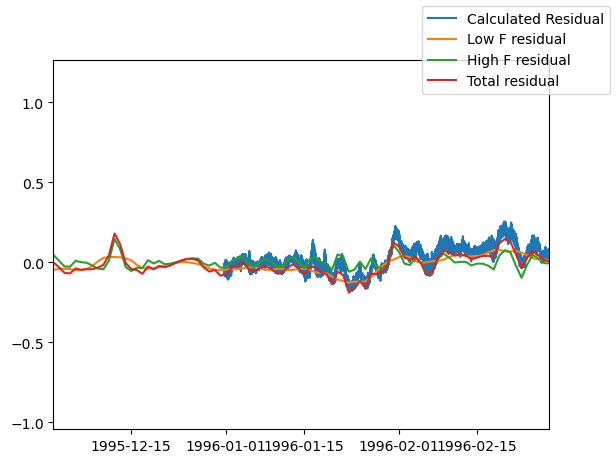

In [38]:
fig, ax =plt.subplots()

ax.plot(t, obs_mb.anomaly - tide_mb.h, label="Calculated Residual") #color="C2")
ax.plot(mb_sam["date"],mb_sam["ResWL_lo"],label="Low F residual")
ax.plot(mb_sam["date"],mb_sam["ResWL_hi"],label="High F residual")
ax.plot(mb_sam["date"],mb_sam["ResWL_total"],label="Total residual")

ax.set_xlim([datetime(1995,12,1,1),datetime(1996,2,28)])
fig.legend()

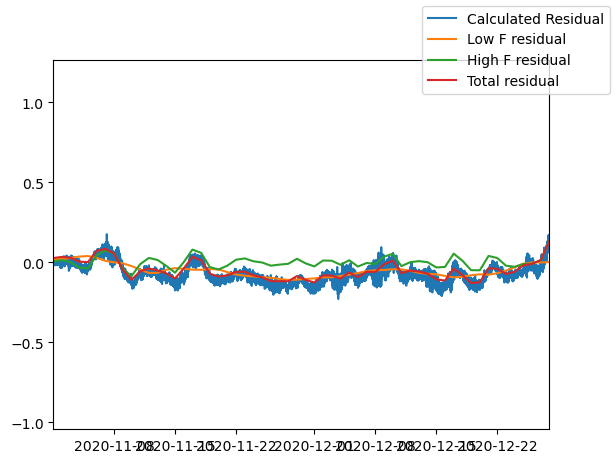

In [40]:
fig, ax =plt.subplots()

ax.plot(t, obs_mb.anomaly - tide_mb.h, label="Calculated Residual") #color="C2")
ax.plot(mb_sam["date"],mb_sam["ResWL_lo"],label="Low F residual")
ax.plot(mb_sam["date"],mb_sam["ResWL_hi"],label="High F residual")
ax.plot(mb_sam["date"],mb_sam["ResWL_total"],label="Total residual")

ax.set_xlim([datetime(2020,11,1,1),datetime(2020,12,28)])
fig.legend()